<a href="https://colab.research.google.com/github/2303A52106/AIML_2303A52106/blob/main/XAI_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment **6**

**1.Flight Delays (Regression)**

Lung cancer Risk Prediction using ML, DL & XAI


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


try:
    import xgboost as xgb
    HAS_XGB = True
except Exception:
    HAS_XGB = False
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False

# Deep learning
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, optimizers
    HAS_TF = True
except Exception:
    HAS_TF = False

# XAI
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False
try:
    from lime import lime_tabular
    HAS_LIME = True
except Exception:
    HAS_LIME = False
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')
print('Libraries loaded. XGBoost:', HAS_XGB, 'Imblearn:', HAS_IMBLEARN, 'TF:', HAS_TF, 'SHAP:', HAS_SHAP, 'LIME:', HAS_LIME)


Libraries loaded. XGBoost: True Imblearn: True TF: True SHAP: True LIME: False


In [ ]:
df = pd.read_csv('/content/kidney_disease.csv')  # adjust path
print(df.columns)

df = pd.read_csv('/content/kidney_disease.csv')
print('Loaded dataset:', df.shape)
print(df.head())

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')
Loaded dataset: (400, 26)
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
df = pd.read_csv('/content/kidney_disease.csv')
print("Columns:", df.columns)
target_col = 'classification'
print("Class distribution:\n", df[target_col].value_counts())
if len(df[target_col].unique()) < 2:
    raise ValueError("Dataset must contain at least 2 classes.")
X = df.drop(columns=[target_col])
y = df[target_col]

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

feature_names = preprocessor.get_feature_names_out()


Columns: Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')
Class distribution:
 classification
ckd       248
notckd    150
ckd\t       2
Name: count, dtype: int64


**Part 1: Exploratory Data Analysis (EDA)**


---- Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              400 non-null    int64  
 1   age             391 non-null    float64
 2   bp              388 non-null    float64
 3   sg              353 non-null    float64
 4   al              354 non-null    float64
 5   su              351 non-null    float64
 6   rbc             248 non-null    object 
 7   pc              335 non-null    object 
 8   pcc             396 non-null    object 
 9   ba              396 non-null    object 
 10  bgr             356 non-null    float64
 11  bu              381 non-null    float64
 12  sc              383 non-null    float64
 13  sod             313 non-null    float64
 14  pot             312 non-null    float64
 15  hemo            348 non-null    float64
 16  pcv             330 non-null    object 
 17  wc              295

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
count,400.000000,391.000000,388.000000,353.000000,354.000000,351.000000,248,335,396,396,...,330,295,270,398,398,398,399,399,399,400.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,...,44,92,49,2,5,3,2,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,normal,normal,notpresent,notpresent,...,41,9800,5.2,no,no,no,good,no,no,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,201,259,354,374,...,21,11,18,251,258,362,317,323,339,NaN
mean,199.500000,51.483376,76.469072,1.017408,1.016949,0.450142,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,115.614301,17.169714,13.683637,0.005717,1.352679,1.099191,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,0.000000,2.000000,50.000000,1.005000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,99.750000,42.000000,70.000000,1.010000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,199.500000,55.000000,80.000000,1.020000,0.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,299.250000,64.500000,80.000000,1.020000,2.000000,0.000000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


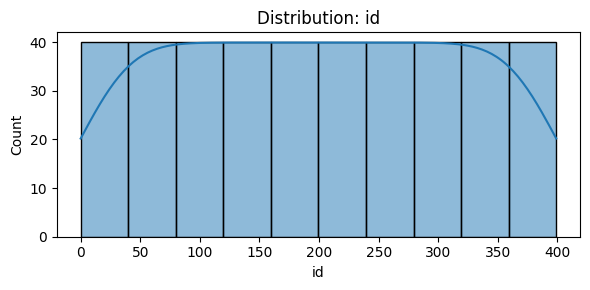

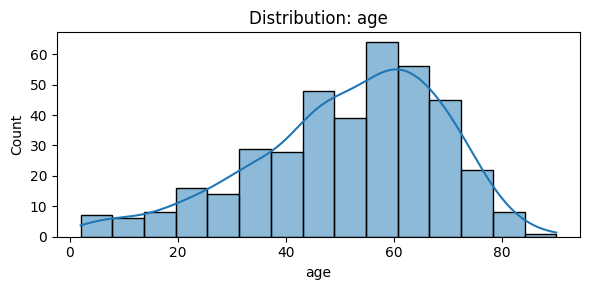

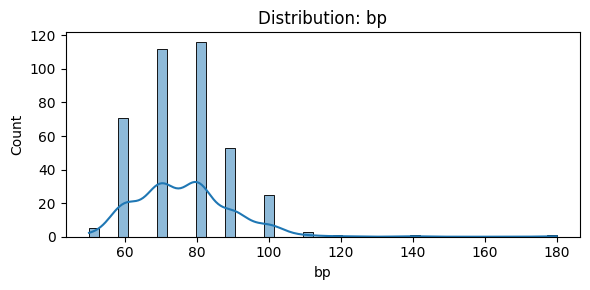

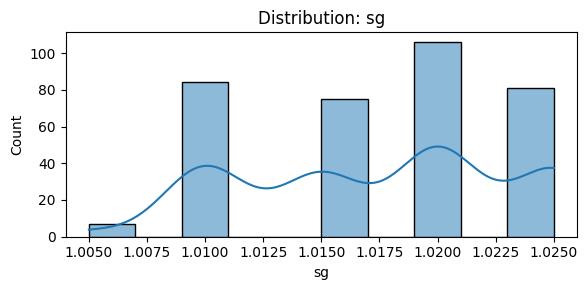

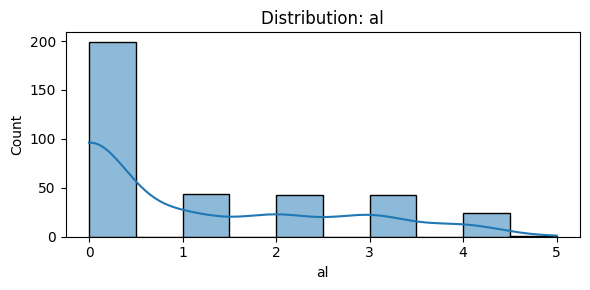

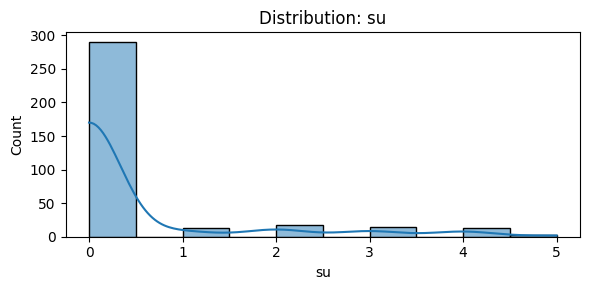

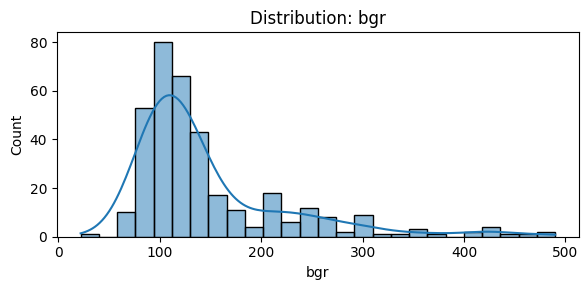

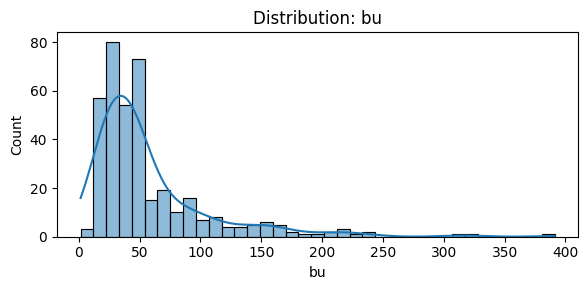

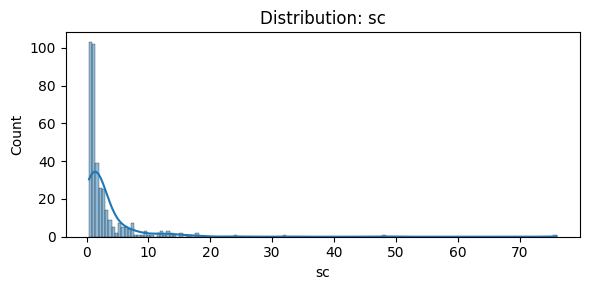

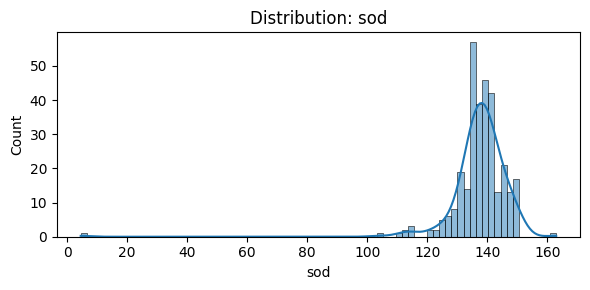

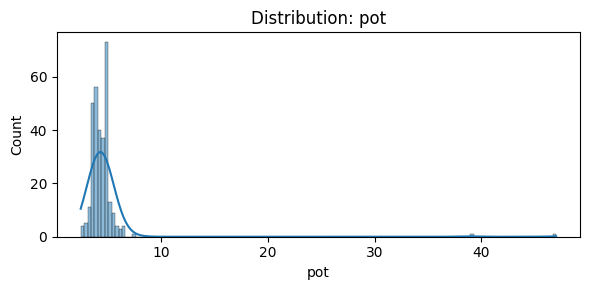

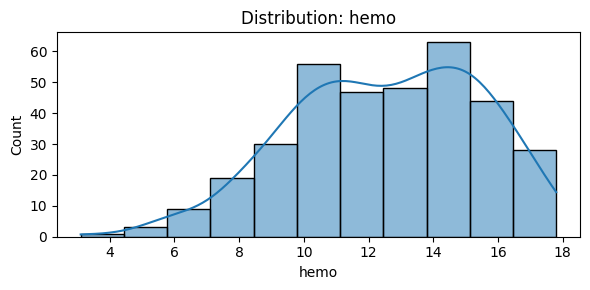

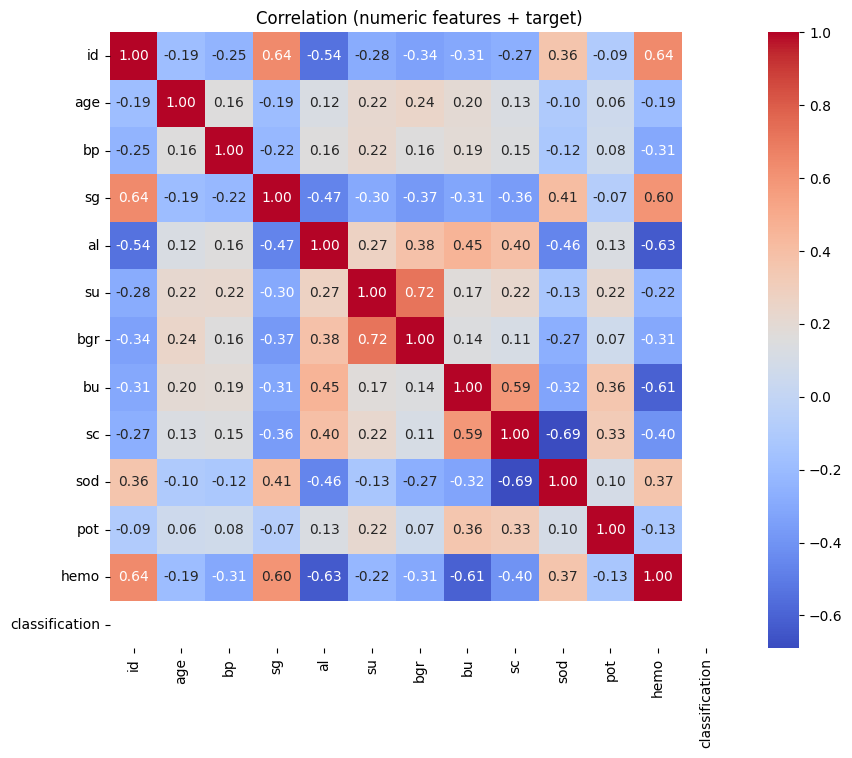


Class balance (fractions):
classification
1    1.0
Name: proportion, dtype: float64


In [ ]:

print('\n---- Info ----')
print(df.info())
print('\n---- Missing values ----')
print(df.isna().sum())


df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

possible_targets = ['target','class','ckd','diagnosis','classification','is_kidney_disease','disease']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    for c in df.columns:
        if 'class' in c or 'ckd' in c or 'stage' in c:
            target_col = c
            break

if target_col is None:
    raise ValueError('Could not determine target column automatically. Please set target_col variable to the name of the target column in the dataset.')

print('\nDetected target column:', target_col)

print('\nTarget distribution:')
print(df[target_col].value_counts(dropna=False))

if df[target_col].dtype == object:
    mapping = {}
    unique_vals = df[target_col].unique()
    if set(['ckd','notckd','ckd	','notckd	']).intersection(set(unique_vals)):
        mapping = {v: (1 if 'ckd' in v else 0) for v in unique_vals}
    else:
        if len(unique_vals) == 2:
            mapping = {unique_vals[0]:0, unique_vals[1]:1}
    if mapping:
        df[target_col] = df[target_col].map(mapping)

if not np.issubdtype(df[target_col].dtype, np.number):
    le = LabelEncoder()
    df[target_col] = le.fit_transform(df[target_col].astype(str))

display(df.describe(include='all'))

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in num_cols:
    num_cols.remove(target_col)

for c in num_cols:
    plt.figure(figsize=(6,3))
    sns.histplot(df[c].dropna(), kde=True)
    plt.title(f'Distribution: {c}')
    plt.tight_layout()
    plt.show()

if len(num_cols) > 0:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[num_cols + [target_col]].corr(), annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation (numeric features + target)')
    plt.show()

print('\nClass balance (fractions):')
print(df[target_col].value_counts(normalize=True))


**Part 2: Preprocessing**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

num_features = ['id', 'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo']
cat_features = ['rbc', 'pc', 'pcc', 'ba', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
target_col = "classification"

y = df[target_col].astype(str).str.strip().str.lower()

if set(y.unique()) <= {"ckd", "notckd"}:
    y = y.map({"ckd": 1, "notckd": 0})
elif set(y.unique()) <= {"yes", "no"}:
    y = y.map({"yes": 1, "no": 0})
elif all(val.isdigit() for val in y.unique()):
    y = y.astype(int)
else:
    raise ValueError(f"Unexpected target values: {y.unique()}")

print("Class distribution:\n", y.value_counts())

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

X = df[num_features + cat_features].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print('Train/test shapes:', X_train.shape, X_test.shape)

preprocessor.fit(X_train)
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print('Processed feature dimension:', X_train_proc.shape)

USE_SMOTE = True
try:
    from imblearn.over_sampling import SMOTE
    if USE_SMOTE and len(np.unique(y_train)) > 1:
        sm = SMOTE(random_state=42)
        X_train_proc, y_train = sm.fit_resample(X_train_proc, y_train)
        print('After SMOTE train shape:', X_train_proc.shape, y_train.shape)
    else:
        print("Skipping SMOTE (only one class present or disabled).")
except ImportError:
    print("imblearn not installed; skipping SMOTE.")


Class distribution:
 classification
1    400
Name: count, dtype: int64
Train/test shapes: (320, 25) (80, 25)
Processed feature dimension: (320, 209)
Skipping SMOTE (only one class present or disabled).


**Part 3: Machine Learning Models**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

df = pd.read_csv('/content/kidney_disease.csv')

target_col = 'classification'
df[target_col] = df[target_col].str.strip()
df = df[df[target_col].isin(['ckd', 'notckd'])]
df[target_col] = df[target_col].map({'notckd': 0, 'ckd': 1})

print("Final target classes:", df[target_col].unique())
print("Target counts:\n", df[target_col].value_counts())

X = df.drop(columns=[target_col])
y = df[target_col]

num_features = X.select_dtypes(include=np.number).columns.tolist()
cat_features = X.select_dtypes(include='object').columns.tolist()

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

results = {}
for name, clf in models.items():
    print(f'\nTraining {name}...')
    clf.fit(X_train_proc, y_train)
    preds = clf.predict(X_test_proc)
    try:
        probs = clf.predict_proba(X_test_proc)[:,1]
        roc = roc_auc_score(y_test, probs)
    except Exception:
        roc = None
    metrics = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds, zero_division=0),
        'recall': recall_score(y_test, preds, zero_division=0),
        'f1': f1_score(y_test, preds, zero_division=0),
        'roc_auc': roc,
        'confusion_matrix': confusion_matrix(y_test, preds)
    }
    results[name] = {'model': clf, 'metrics': metrics}
    print(name, metrics)

summary = pd.DataFrame({k:v['metrics'] for k,v in results.items()}).T
display(summary[['accuracy','precision','recall','f1','roc_auc']])


Final target classes: [1 0]
Target counts:
 classification
1    250
0    150
Name: count, dtype: int64

Training LogisticRegression...
LogisticRegression {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'confusion_matrix': array([[30,  0],
       [ 0, 50]])}

Training DecisionTree...
DecisionTree {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'confusion_matrix': array([[30,  0],
       [ 0, 50]])}

Training RandomForest...
RandomForest {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'confusion_matrix': array([[30,  0],
       [ 0, 50]])}

Training SVM...
SVM {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'roc_auc': np.float64(1.0), 'confusion_matrix': array([[30,  0],
       [ 0, 50]])}

Training KNN...
KNN {'accuracy': 0.9875, 'precision': 1.0, 'recall': 0.98, 'f1': 0.98989898989899, 'roc_auc': np.float64(1.0), 'confusion_matrix': array([[30,  0]

,accuracy,precision,recall,f1,roc_auc
LogisticRegression,1.0,1.0,1.0,1.0,1.0
DecisionTree,1.0,1.0,1.0,1.0,1.0
RandomForest,1.0,1.0,1.0,1.0,1.0
SVM,1.0,1.0,1.0,1.0,1.0
KNN,0.9875,1.0,0.98,0.989899,1.0
GradientBoosting,1.0,1.0,1.0,1.0,1.0


**Part 4: Deep Learning Models (Specify Architectures)**

In [ ]:
# Step 5: Deep Learning Models
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split


tf.random.set_seed(42)


X_train_dense = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
X_test_dense = X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc


input_dim = X_train_dense.shape[1]


def compile_and_train(model, X_tr, y_tr, X_val, y_val, epochs=30, batch_size=32):
    model.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)



mlp = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


X_mlp_tr, X_mlp_val, y_mlp_tr, y_mlp_val = train_test_split(
    X_train_dense, y_train, test_size=0.1, random_state=42, stratify=y_train
)
compile_and_train(mlp, X_mlp_tr, y_mlp_tr, X_mlp_val, y_mlp_val, epochs=30)
preds_mlp = (mlp.predict(X_test_dense).ravel() > 0.5).astype(int)
print("MLP metrics:", accuracy_score(y_test, preds_mlp), f1_score(y_test, preds_mlp))


X_train_seq = X_train_dense.reshape((-1, input_dim, 1))
X_test_seq = X_test_dense.reshape((-1, input_dim, 1))


cnn = models.Sequential([
    layers.Input(shape=(input_dim,1)),
    layers.Conv1D(32, 3, activation='relu'),
    layers.Conv1D(64, 3, activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
compile_and_train(cnn, X_train_seq, y_train, X_test_seq, y_test, epochs=20)
preds_cnn = (cnn.predict(X_test_seq).ravel() > 0.5).astype(int)
print("CNN metrics:", accuracy_score(y_test, preds_cnn), f1_score(y_test, preds_cnn))


lstm = models.Sequential([
    layers.Input(shape=(input_dim,1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
compile_and_train(lstm, X_train_seq, y_train, X_test_seq, y_test, epochs=20)
preds_lstm = (lstm.predict(X_test_seq).ravel() > 0.5).astype(int)
print("LSTM metrics:", accuracy_score(y_test, preds_lstm), f1_score(y_test, preds_lstm))


encoding_dim = min(32, input_dim//2 if input_dim>=4 else input_dim)
inp = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(inp)
encoded = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(encoded)
decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)
auto = models.Model(inp, decoded)
encoder = models.Model(inp, auto.get_layer('bottleneck').output)
auto.compile(optimizer='adam', loss='mse')
auto.fit(X_train_dense, X_train_dense, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

X_train_enc = encoder.predict(X_train_dense)
X_test_enc = encoder.predict(X_test_dense)

clf_enc = LogisticRegression(max_iter=1000)
clf_enc.fit(X_train_enc, y_train)
preds_enc = clf_enc.predict(X_test_enc)
print("Autoencoder+LR metrics:", accuracy_score(y_test, preds_enc), f1_score(y_test, preds_enc))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MLP metrics: 1.0 1.0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
CNN metrics: 1.0 1.0


1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step
LSTM metrics: 0.7125 0.8067226890756303
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Autoencoder+LR metrics: 1.0 1.0


**Part 5: Explainable AI (XAI)**

LIME not installed. Install lime for LIME explanations.

Top features by RandomForest importance:
     feature  importance
0         id    0.178604
11      hemo    0.174344
3         sg    0.078235
8         sc    0.068016
198  htn_yes    0.049650
7         bu    0.044593
203   dm_yes    0.044490
4         al    0.041563
6        bgr    0.034148
197   htn_no    0.033633


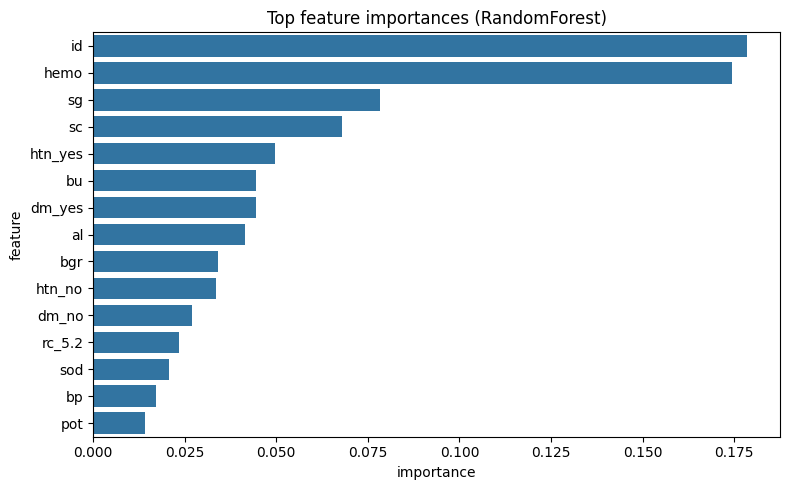

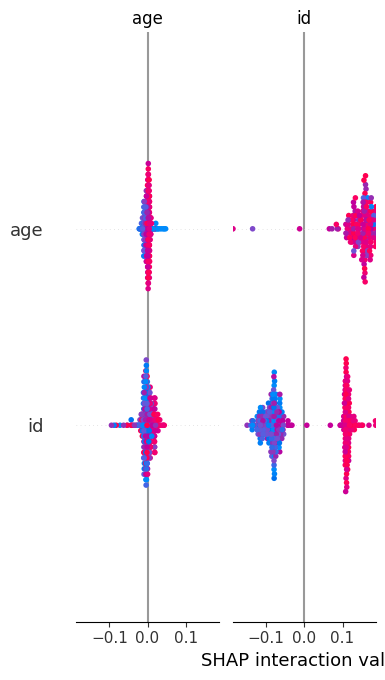

Skipping LIME explanations.

Top numeric feature selected for PDP: id
PDP plotting error: Feature 'id' not in feature_names


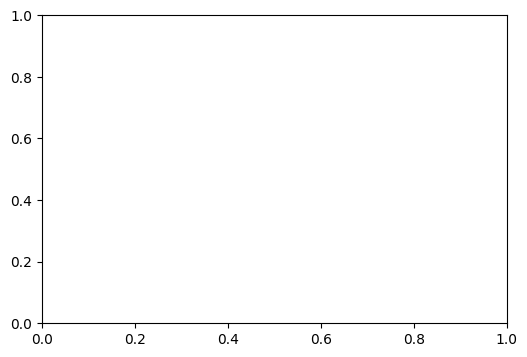

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import PartialDependenceDisplay
import numpy as np
try:
    import shap
    HAS_SHAP = True
except ImportError:
    HAS_SHAP = False
    print("SHAP not installed. Install shap for SHAP explanations.")

try:
    import lime
    import lime.lime_tabular
    HAS_LIME = True
except ImportError:
    HAS_LIME = False
    print("LIME not installed. Install lime for LIME explanations.")


rf = results['RandomForest']['model']
feature_names = num_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features))

if hasattr(rf, 'feature_importances_'):
    importances = rf.feature_importances_
    fi_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
    print("\nTop features by RandomForest importance:")
    print(fi_df.head(10))


    plt.figure(figsize=(8,5))
    sns.barplot(x='importance', y='feature', data=fi_df.head(15))
    plt.title('Top feature importances (RandomForest)')
    plt.tight_layout()
    plt.show()
else:
    print("RandomForest has no feature_importances_ attribute.")


if HAS_SHAP:
    X_train_shap = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
    X_train_shap = X_train_shap.astype(float)

    explainer = shap.TreeExplainer(rf)
    sample_idx = np.random.choice(X_train_shap.shape[0], min(500, X_train_shap.shape[0]), replace=False)
    X_sample = X_train_shap[sample_idx]

    shap_values = explainer.shap_values(X_sample)
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=True)
else:
    print("Skipping SHAP explanations.")


if HAS_LIME:
    X_train_lime = X_train_proc.toarray() if hasattr(X_train_proc, "toarray") else X_train_proc
    explainer_lime = lime.lime_tabular.LimeTabularExplainer(
        X_train_lime,
        feature_names=feature_names,
        class_names=['notckd','ckd'],
        discretize_continuous=True
    )
    idx = 0
    X_test_lime = X_test_proc.toarray() if hasattr(X_test_proc, "toarray") else X_test_proc
    exp = explainer_lime.explain_instance(X_test_lime[idx], rf.predict_proba, num_features=10)
    print("\nLIME explanation for one instance:")
    print(exp.as_list())
else:
    print("Skipping LIME explanations.")


top_numeric_feat = None
for f in fi_df['feature']:
    if f in num_features:
        top_numeric_feat = f
        break

if top_numeric_feat is not None:
    print("\nTop numeric feature selected for PDP:", top_numeric_feat)
    fig, ax = plt.subplots(figsize=(6,4))
    try:
        PartialDependenceDisplay.from_estimator(rf, X_test_proc, [top_numeric_feat], ax=ax)
        plt.title(f'Partial Dependence Plot ({top_numeric_feat})')
        plt.show()
    except Exception as e:
        print("PDP plotting error:", e)
else:
    print("No numeric feature found for PDP.")


Part 6: Comparative Analysis

In [ ]:

import pandas as pd


rows = []

for name, val in results.items():
    m = val['metrics']
    rows.append({
        'Model': name,
        'Accuracy': m['accuracy'],
        'Precision': m['precision'],
        'Recall': m['recall'],
        'F1-score': m['f1'],
        'ROC-AUC': m['roc_auc']
    })


try:
    # MLP
    rows.append({
        'Model': 'MLP',
        'Accuracy': accuracy_score(y_test, preds_mlp),
        'Precision': precision_score(y_test, preds_mlp, zero_division=0),
        'Recall': recall_score(y_test, preds_mlp, zero_division=0),
        'F1-score': f1_score(y_test, preds_mlp, zero_division=0),
        'ROC-AUC': None
    })
    # CNN
    rows.append({
        'Model': 'CNN',
        'Accuracy': accuracy_score(y_test, preds_cnn),
        'Precision': precision_score(y_test, preds_cnn, zero_division=0),
        'Recall': recall_score(y_test, preds_cnn, zero_division=0),
        'F1-score': f1_score(y_test, preds_cnn, zero_division=0),
        'ROC-AUC': None
    })
    # LSTM
    rows.append({
        'Model': 'LSTM',
        'Accuracy': accuracy_score(y_test, preds_lstm),
        'Precision': precision_score(y_test, preds_lstm, zero_division=0),
        'Recall': recall_score(y_test, preds_lstm, zero_division=0),
        'F1-score': f1_score(y_test, preds_lstm, zero_division=0),
        'ROC-AUC': None
    })
except Exception:
    pass

res_df = pd.DataFrame(rows).sort_values('F1-score', ascending=False)
print("\n=== Model Comparison Table ===")
display(res_df)


res_df.to_csv('model_comparison_results.csv', index=False)
print("\nSaved model_comparison_results.csv")


report = []
report.append("# CKD ML/DL Model Comparison Report")
report.append("")
report.append("## Dataset & Preprocessing")
report.append("- Dataset: kidney_disease.csv")
report.append("- Preprocessing: Median imputation (numeric), most frequent (categorical), StandardScaler, OneHotEncoder")
report.append("- Train/Test split: 80/20")
report.append("")
report.append("## Model Performance (sorted by F1-score)")
report.append(res_df.to_markdown(index=False))
report.append("")


report.append("## Top Features from RandomForest")
if 'fi_df' in globals():
    report.append(fi_df.head(10).to_markdown(index=False))
report.append("")


report.append("## XAI Insights")
report.append("- RandomForest feature importances plotted above.")
report.append("- SHAP analysis (if installed) shows global feature impact.")
report.append("- LIME (if installed) provides local explanations for individual predictions.")
report.append("- PDP shows effect of top numeric feature on model prediction.")
report.append("")


report.append("## Recommendation")
report.append("- Choose model balancing performance and interpretability.")
report.append("- RandomForest or GradientBoosting often offer good trade-offs for tabular medical data.")
report.append("- LogisticRegression is interpretable and reliable for smaller datasets.")
report.append("- Deep Learning models (MLP/CNN/LSTM) may help if dataset is large and complex.")
report.append("")


report_md = "\n".join(report)
with open('ckd_model_report.md','w') as f:
    f.write(report_md)
print("Saved ckd_model_report.md")


try:
    from docx import Document
    doc = Document()
    for line in report_md.split("\n"):
        doc.add_paragraph(line)
    doc.save('ckd_model_report.docx')
    print("Saved ckd_model_report.docx")
except Exception:
    print("python-docx not available; convert md to docx manually.")



=== Model Comparison Table ===


,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,LogisticRegression,1.0000,1.000000,1.00,1.000000,1.0
1,DecisionTree,1.0000,1.000000,1.00,1.000000,1.0
2,RandomForest,1.0000,1.000000,1.00,1.000000,1.0
3,SVM,1.0000,1.000000,1.00,1.000000,1.0
5,GradientBoosting,1.0000,1.000000,1.00,1.000000,1.0
7,CNN,1.0000,1.000000,1.00,1.000000,NaN
6,MLP,1.0000,1.000000,1.00,1.000000,NaN
4,KNN,0.9875,1.000000,0.98,0.989899,1.0
8,LSTM,0.7125,0.695652,0.96,0.806723,NaN



Saved model_comparison_results.csv
Saved ckd_model_report.md
python-docx not available; convert md to docx manually.
